In [147]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
%load_ext autoreload
%autoreload 2

from src.dataset import NodulesDataset
from src.augmentations import create_mip
from src.custom_models import resnet2d

### Prepare data

In [3]:
dataset = NodulesDataset("data/nodules")

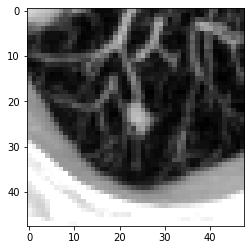

In [4]:
plt.imshow(create_mip(dataset[4][0]), cmap="gray")

In [5]:
dataset_to_visualize = NodulesDataset("data/nodules", transform=transforms.Compose([create_mip]))

In [6]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6):
    np.random.seed(0)
    classes_ids = [0] * len(classes)
    for i, class_ in enumerate(classes):
        classes_ids[i] = np.random.choice(np.where(dataset.labels == class_)[0], columns, replace=False)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            ax[i, j].imshow(dataset[classes_ids[i][j]][0], cmap="gray")
            ax[i, j].axis('off')

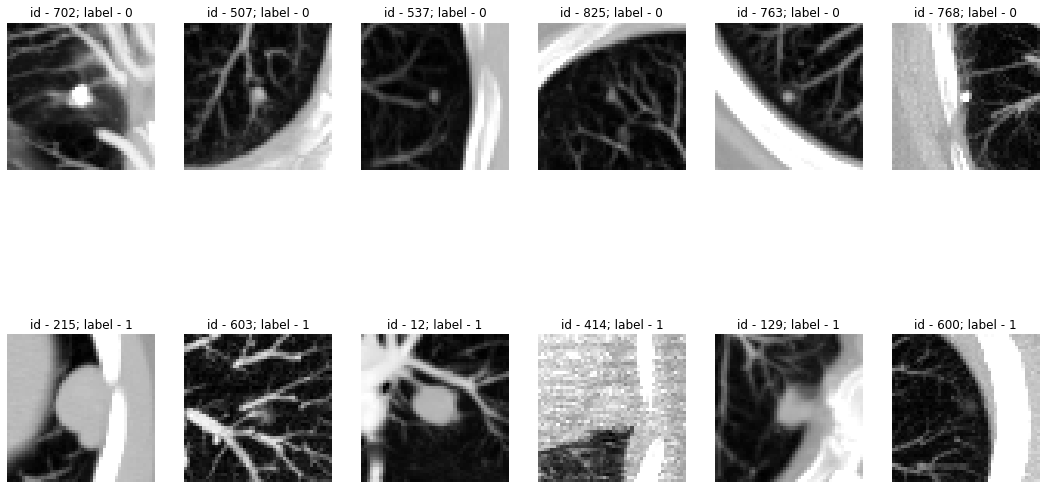

In [7]:
visualize_classes(dataset_to_visualize)

In [8]:
original_dataset = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
            lambda x: x/255,
            lambda x: x[np.newaxis, :, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
            lambda x: transforms.RandomHorizontalFlip(p=0.5)(x[0]).unsqueeze(0),
            lambda x: transforms.RandomVerticalFlip(p=0.5)(x[0]).unsqueeze(0),
#             transforms.ToTensor(),
#             lambda x: torchvision.transforms.functional.resize(x, 48),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
)

In [9]:
mean = np.mean([np.mean(sample[0][0].numpy()) for sample in original_dataset])
std = np.mean([np.std(sample[0][0].numpy()) for sample in original_dataset])
mean, std

(0.3011869, 0.25784153)

In [10]:
original_dataset = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
#             lambda x: print(x.shape),
            lambda x: create_mip(x),
            lambda x: x/255,
#             lambda x: x + (np.random.normal(0,0.02,(48, 48)) * np.random.sample()),
#             lambda x: (x - mean) / std,
            lambda x: x[np.newaxis, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
#             lambda x: transforms.RandomHorizontalFlip(p=0.5)(x[0]).unsqueeze(0),
#             lambda x: transforms.RandomVerticalFlip(p=0.5)(x[0]).unsqueeze(0),
#             transforms.ToTensor(),
#             lambda x: torchvision.transforms.functional.resize(x, 48),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
)

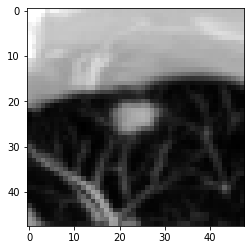

In [11]:
plt.imshow(original_dataset[0][0][0], cmap="gray")

In [12]:
original_dataset[0][0].dtype

torch.float32

In [13]:
train_size = int(0.8 * len(original_dataset))
test_size = len(original_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    original_dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=2
)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 1, 48, 48]), torch.Size([32]))

In [16]:
dataloaders = {"train": train_loader, "val": test_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(test_dataset)}

### Train model

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            probabilities = []
            full_labels = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                full_labels.extend(list(labels.cpu().detach().numpy()))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_ap = average_precision_score(full_labels, probabilities)

            if phase == "val":
                scheduler.step(epoch_loss)
            else:
                writer.add_scalar(f'LR/{phase}', optimizer.param_groups[0]["lr"], epoch)

            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            writer.add_scalar(f'Average precision/{phase}', epoch_ap, epoch)

            print("{} Loss: {:.4f} Acc: {:.4f} LR: {} AP: {}".format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]["lr"], epoch_ap))

            # deep copy the model
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val loss: {:4f} Best epoch: {}".format(best_loss, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
device = "cuda:0"
# device = "cpu"

In [19]:
model_ft = resnet2d.resnet18without_batch_norm()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-05)

In [20]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.6275 Acc: 0.6682 LR: 0.001 AP: 0.6935490706219796


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.8485 Acc: 0.4643 LR: 0.001 AP: 0.6862710149574731

Epoch 1/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.5447 Acc: 0.7549 LR: 0.001 AP: 0.8380359676527227


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5868 Acc: 0.6964 LR: 0.001 AP: 0.8452778569113595

Epoch 2/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4937 Acc: 0.8146 LR: 0.001 AP: 0.8906562398759797


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5147 Acc: 0.7976 LR: 0.001 AP: 0.7784539965731014

Epoch 3/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4777 Acc: 0.8236 LR: 0.001 AP: 0.899080765931518


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4831 Acc: 0.8155 LR: 0.001 AP: 0.858629054252636

Epoch 4/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4593 Acc: 0.8505 LR: 0.001 AP: 0.9096659205193085


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4672 Acc: 0.8393 LR: 0.001 AP: 0.8659757023868448

Epoch 5/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4957 Acc: 0.8102 LR: 0.001 AP: 0.8017541561089576


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5446 Acc: 0.7560 LR: 0.001 AP: 0.8271937689017347

Epoch 6/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.5058 Acc: 0.8027 LR: 0.001 AP: 0.820057561369663


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4681 Acc: 0.8333 LR: 0.001 AP: 0.9040503421856606

Epoch 7/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4781 Acc: 0.8326 LR: 0.001 AP: 0.8838286216404356


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4908 Acc: 0.7976 LR: 0.001 AP: 0.8578855155661097

Epoch 8/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4490 Acc: 0.8580 LR: 0.001 AP: 0.9070970366265809


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4820 Acc: 0.8333 LR: 0.001 AP: 0.8650078374686041

Epoch 9/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4252 Acc: 0.8879 LR: 0.001 AP: 0.9229464849511368


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5046 Acc: 0.7976 LR: 0.001 AP: 0.902783131679898

Epoch 10/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4456 Acc: 0.8655 LR: 0.001 AP: 0.8967325235912249


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.5050 Acc: 0.7917 LR: 0.0001 AP: 0.8884717743240222

Epoch 11/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4059 Acc: 0.9043 LR: 0.0001 AP: 0.933695574189197


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4782 Acc: 0.8214 LR: 0.0001 AP: 0.9139403178875521

Epoch 12/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3953 Acc: 0.9118 LR: 0.0001 AP: 0.9377268980689426


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4643 Acc: 0.8393 LR: 0.0001 AP: 0.9049463326631633

Epoch 13/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3805 Acc: 0.9357 LR: 0.0001 AP: 0.9464152160539362


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4741 Acc: 0.8155 LR: 0.0001 AP: 0.9021104262176616

Epoch 14/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3705 Acc: 0.9402 LR: 0.0001 AP: 0.9454288596178643


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4700 Acc: 0.8333 LR: 0.0001 AP: 0.9058675026028836

Epoch 15/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3664 Acc: 0.9462 LR: 0.0001 AP: 0.957990385584852


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4642 Acc: 0.8333 LR: 0.0001 AP: 0.9126738250690336

Epoch 16/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3645 Acc: 0.9492 LR: 0.0001 AP: 0.9518749244849081


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4645 Acc: 0.8393 LR: 0.0001 AP: 0.9105460290631189

Epoch 17/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3611 Acc: 0.9522 LR: 0.0001 AP: 0.9491199659973341


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4494 Acc: 0.8571 LR: 0.0001 AP: 0.9187998689384884

Epoch 18/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3554 Acc: 0.9596 LR: 0.0001 AP: 0.9594783681961793


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4535 Acc: 0.8571 LR: 0.0001 AP: 0.9114076810329238

Epoch 19/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3545 Acc: 0.9596 LR: 0.0001 AP: 0.9626881556464354


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4578 Acc: 0.8512 LR: 0.0001 AP: 0.9122425687752529

Epoch 20/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3551 Acc: 0.9581 LR: 0.0001 AP: 0.9519381689293905


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4640 Acc: 0.8393 LR: 0.0001 AP: 0.9099515887918785

Epoch 21/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3560 Acc: 0.9567 LR: 0.0001 AP: 0.946942167786605


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4607 Acc: 0.8512 LR: 0.0001 AP: 0.9153514561271522

Epoch 22/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3571 Acc: 0.9567 LR: 0.0001 AP: 0.9637625514098496


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4599 Acc: 0.8452 LR: 0.0001 AP: 0.9208064665468972

Epoch 23/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3559 Acc: 0.9581 LR: 0.0001 AP: 0.95448925886271


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4553 Acc: 0.8512 LR: 1e-05 AP: 0.9214484634116248

Epoch 24/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3527 Acc: 0.9611 LR: 1e-05 AP: 0.9660902645292287


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4542 Acc: 0.8571 LR: 1e-05 AP: 0.9227801356341764

Epoch 25/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3513 Acc: 0.9626 LR: 1e-05 AP: 0.9659166554349523


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4541 Acc: 0.8571 LR: 1e-05 AP: 0.9209205882024594

Epoch 26/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3497 Acc: 0.9641 LR: 1e-05 AP: 0.9580002524714709


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4559 Acc: 0.8512 LR: 1e-05 AP: 0.9194834903547867

Epoch 27/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3510 Acc: 0.9626 LR: 1e-05 AP: 0.961278392191268


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4552 Acc: 0.8512 LR: 1e-05 AP: 0.9196009222276471

Epoch 28/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3532 Acc: 0.9596 LR: 1e-05 AP: 0.9626500303396287


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4530 Acc: 0.8571 LR: 1e-05 AP: 0.9188636375876514

Epoch 29/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3513 Acc: 0.9626 LR: 1e-05 AP: 0.9605903942299412


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4574 Acc: 0.8571 LR: 1e-05 AP: 0.917486117939573

Epoch 30/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3512 Acc: 0.9626 LR: 1e-05 AP: 0.9602085832298629


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4584 Acc: 0.8571 LR: 1e-05 AP: 0.9169567107533686

Epoch 31/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3516 Acc: 0.9611 LR: 1e-05 AP: 0.9661571476837573


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4517 Acc: 0.8571 LR: 1e-05 AP: 0.9179873809908667

Epoch 32/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3505 Acc: 0.9626 LR: 1e-05 AP: 0.9475063146259257


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4535 Acc: 0.8512 LR: 1e-05 AP: 0.9168309423900978

Epoch 33/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3501 Acc: 0.9641 LR: 1e-05 AP: 0.9544770306558864


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4548 Acc: 0.8571 LR: 1e-05 AP: 0.9174109125776418

Epoch 34/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3496 Acc: 0.9641 LR: 1e-05 AP: 0.9550587955171215


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4524 Acc: 0.8571 LR: 1e-05 AP: 0.9176219164132113

Epoch 35/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3516 Acc: 0.9611 LR: 1e-05 AP: 0.9631956115019453


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4489 Acc: 0.8571 LR: 1e-05 AP: 0.9184828648883709

Epoch 36/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3501 Acc: 0.9626 LR: 1e-05 AP: 0.9653884159787322


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4489 Acc: 0.8631 LR: 1e-05 AP: 0.9206235855443036

Epoch 37/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3493 Acc: 0.9641 LR: 1e-05 AP: 0.9663285609968286


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4550 Acc: 0.8512 LR: 1e-05 AP: 0.920038818645338

Epoch 38/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3508 Acc: 0.9611 LR: 1e-05 AP: 0.9643535215958682


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4592 Acc: 0.8512 LR: 1e-05 AP: 0.91757809057277

Epoch 39/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3493 Acc: 0.9641 LR: 1e-05 AP: 0.9578775820717711


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4590 Acc: 0.8512 LR: 1e-05 AP: 0.9196924194963417

Epoch 40/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3495 Acc: 0.9641 LR: 1e-05 AP: 0.9633912952637396


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4579 Acc: 0.8571 LR: 1e-05 AP: 0.9198648524189942

Epoch 41/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.9641 LR: 1e-05 AP: 0.9593372774311512


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4571 Acc: 0.8571 LR: 1e-05 AP: 0.9210039235832742

Epoch 42/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.9641 LR: 1e-05 AP: 0.9609505703693537


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4597 Acc: 0.8512 LR: 1e-05 AP: 0.9204464442792362

Epoch 43/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3493 Acc: 0.9641 LR: 1e-05 AP: 0.9595718062385543


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4598 Acc: 0.8512 LR: 1e-05 AP: 0.9180028289374813

Epoch 44/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.9641 LR: 1e-05 AP: 0.9654869951069749


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4601 Acc: 0.8512 LR: 1e-05 AP: 0.9188439812310198

Epoch 45/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3520 Acc: 0.9611 LR: 1e-05 AP: 0.956348728044919


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4574 Acc: 0.8571 LR: 1e-05 AP: 0.9199655628855581

Epoch 46/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.9641 LR: 1e-05 AP: 0.957830590800018


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4558 Acc: 0.8512 LR: 1e-05 AP: 0.920887687930254

Epoch 47/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3501 Acc: 0.9626 LR: 1e-05 AP: 0.9592782818959602


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4568 Acc: 0.8571 LR: 1e-05 AP: 0.9210783471945774

Epoch 48/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3494 Acc: 0.9641 LR: 1e-05 AP: 0.9573240366020105


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.4569 Acc: 0.8571 LR: 1e-05 AP: 0.9200434501789573

Epoch 49/49
----------


  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3502 Acc: 0.9641 LR: 1e-05 AP: 0.9500626962585493


100%|██████████| 6/6 [00:00<00:00, 21.96it/s]

val Loss: 0.4516 Acc: 0.8571 LR: 1e-05 AP: 0.9199352803107311

Training complete in 0m 55s
Best val loss: 0.448904 Best epoch: 35


In [260]:
# FGSM attack code
def fgsm_attack_1(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [257]:
def test( model, device, test_loader, criterion, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)
#         loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack_1(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [243]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=1
)

In [244]:
epsilons = list(map(lambda x: round(x, 3), np.arange(0, 0.31, 0.025)))
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_ft, device, test_loader, criterion, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test Accuracy = 135 / 168 = 0.8035714285714286
Epsilon: 0.025	Test Accuracy = 85 / 168 = 0.5059523809523809
Epsilon: 0.05	Test Accuracy = 73 / 168 = 0.43452380952380953
Epsilon: 0.075	Test Accuracy = 63 / 168 = 0.375
Epsilon: 0.1	Test Accuracy = 54 / 168 = 0.32142857142857145
Epsilon: 0.125	Test Accuracy = 53 / 168 = 0.31547619047619047
Epsilon: 0.15	Test Accuracy = 53 / 168 = 0.31547619047619047
Epsilon: 0.175	Test Accuracy = 53 / 168 = 0.31547619047619047
Epsilon: 0.2	Test Accuracy = 52 / 168 = 0.30952380952380953
Epsilon: 0.225	Test Accuracy = 51 / 168 = 0.30357142857142855
Epsilon: 0.25	Test Accuracy = 50 / 168 = 0.2976190476190476
Epsilon: 0.275	Test Accuracy = 50 / 168 = 0.2976190476190476
Epsilon: 0.3	Test Accuracy = 50 / 168 = 0.2976190476190476


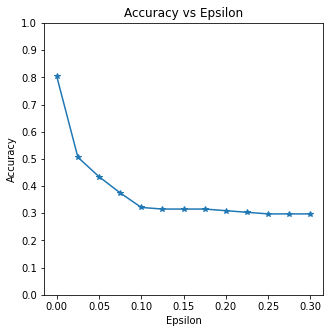

In [245]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

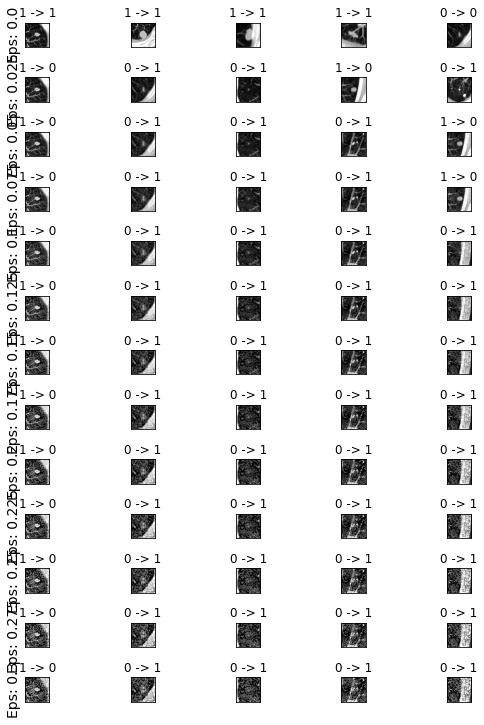

In [254]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Adversarial train

In [255]:
# FGSM attack code
def fgsm_attack_2(model, criterion, inputs, labels, epsilon):
    delta = torch.zeros_like(inputs, requires_grad=True)
    output = model(inputs + delta)
    loss = criterion(output, labels)
    loss.backward()
    noise = epsilon * delta.grad.detach().sign()
    return inputs + noise

In [371]:
def pgd_linf(model, criterion, X, y, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = criterion(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return X + delta.detach()

In [372]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities


def epoch_adversarial(loader, model, device, criterion, eps, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = pgd_linf(model, criterion, inputs, labels, eps)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities


In [373]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss/{phase}', loss, epoch_num)
    writer.add_scalar(f'Accuracy/{phase}', acc, epoch_num)
    writer.add_scalar(f'Average precision/{phase}', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR/{phase}', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [378]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    writer = SummaryWriter()
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        _, _, _ = epoch_adversarial(train_loader, model, device, criterion, 0.05, opt = optimizer)
        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)
        adv_loss, adv_labels, adv_prob = epoch_adversarial(test_loader, model, device, criterion, 0.1)

        print_metrics(writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(writer, "val", epoch_num, val_loss, val_labels, val_prob)
        print_metrics(writer, "adv", epoch_num, adv_loss, adv_labels, adv_prob)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [389]:
model_ft = resnet2d.resnet18without_batch_norm()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-05)

In [396]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4496 Acc: 0.8610 AP: 0.9262 LR: 0.0001
val Loss: 0.6165 Acc: 0.8512 AP: 0.8427
adv Loss: 0.7552 Acc: 0.3988 AP: 0.3352

Epoch 1/14
----------
train Loss: 0.4411 Acc: 0.8565 AP: 0.9296 LR: 0.0001
val Loss: 0.6283 Acc: 0.8571 AP: 0.8843
adv Loss: 0.7386 Acc: 0.4464 AP: 0.3297

Epoch 2/14
----------
train Loss: 0.4346 Acc: 0.8714 AP: 0.9366 LR: 1e-05
val Loss: 0.6267 Acc: 0.8393 AP: 0.8909
adv Loss: 0.7416 Acc: 0.4345 AP: 0.3294

Epoch 3/14
----------
train Loss: 0.4350 Acc: 0.8714 AP: 0.9278 LR: 1e-05
val Loss: 0.6291 Acc: 0.8333 AP: 0.8857
adv Loss: 0.7434 Acc: 0.4048 AP: 0.3283

Epoch 4/14
----------
train Loss: 0.4369 Acc: 0.8595 AP: 0.9328 LR: 1e-05
val Loss: 0.6287 Acc: 0.8393 AP: 0.8896
adv Loss: 0.7410 Acc: 0.4345 AP: 0.3298

Epoch 5/14
----------
train Loss: 0.4340 Acc: 0.8729 AP: 0.9410 LR: 1e-05
val Loss: 0.6280 Acc: 0.8393 AP: 0.8829
adv Loss: 0.7455 Acc: 0.4107 AP: 0.3274

Epoch 6/14
----------
train Loss: 0.4339 Acc: 0.8714 AP: 0.9370 LR: 

(tensor([[0.3484, 0.6516]], device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor(0, device='cuda:0'))

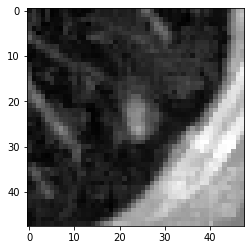

In [397]:
inputs, labels = test_dataset[5]
inputs, labels = inputs.to(device), torch.tensor(labels).to(device)
# ae = fgsm_attack_2(model_ft, criterion, inputs.unsqueeze(0), labels.unsqueeze(0), 0.1)
ae = pgd_linf(model_ft, criterion, inputs.unsqueeze(0), labels.unsqueeze(0), 0.1)
ae_1 = ae
# plt.imshow((ae - inputs).cpu()[0][0], cmap="gray")
plt.imshow(ae.cpu()[0][0], cmap="gray")
model_ft(ae), labels

tensor([[0.3600, 0.6400]], device='cuda:0', grad_fn=<SoftmaxBackward>)

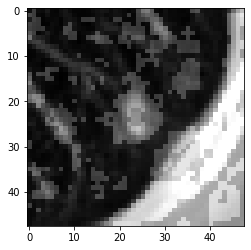

In [398]:
inputs, labels = test_dataset[5]
inputs, labels = inputs.to(device).unsqueeze(0), torch.tensor(labels).to(device).unsqueeze(0)

inputs.requires_grad = True
output = model_ft(inputs)
loss = criterion(output, labels)
model_ft.zero_grad()
loss.backward()

ae = fgsm_attack_1(inputs, 0.1, inputs.grad.data)
ae_2 = ae

# plt.imshow((ae - inputs).cpu().detach().numpy()[0][0], cmap="gray")
plt.imshow(ae.cpu().detach().numpy()[0][0], cmap="gray")

model_ft(ae)

In [399]:
results = []
with torch.no_grad():
    for i, (input_, label) in tqdm(enumerate(original_dataset), total=len(original_dataset)):
        input_ = input_.to(device)
        labels = labels.to(device)
        output = model_ft(input_.unsqueeze(0))
        _, pred = torch.max(output, 1)

        results.append({
            "id": i,
            "prob": output.cpu().numpy()[0][1],
            "y_pred": pred.cpu().numpy()[0],
            "y_true": label,
        })

100%|██████████| 837/837 [00:04<00:00, 201.10it/s]


(array([ 69., 141., 101.,  66.,  40.,  17.,  26.,  68., 183., 126.]),
 array([0.25733954, 0.29737657, 0.33741361, 0.37745064, 0.41748768,
        0.45752472, 0.49756175, 0.53759879, 0.57763582, 0.61767286,
        0.6577099 ]),
 <BarContainer object of 10 artists>)

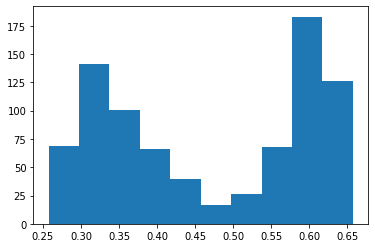

In [400]:
plt.hist(pd.DataFrame(results)["prob"])

In [401]:
save_path = f"models/resnet18_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'models/resnet18_2021-04-03_03:04:07.pt'

In [19]:
model = custom_models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)